In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cv2
import os
import torch
import librosa

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torch
from torch import nn
from torch.utils import data
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.utils.data as utils

from torch.autograd import Variable

import time

In [2]:
# Camera RGB

'''cam = cv2.VideoCapture(0)
while True:
    ret_val, img = cam.read()
    cv2.imshow('my webcam', img)
    if cv2.waitKey(1) == 27: 
        break  # esc to quit
    mean_r = np.mean(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
cv2.destroyAllWindows()'''

"cam = cv2.VideoCapture(0)\nwhile True:\n    ret_val, img = cam.read()\n    cv2.imshow('my webcam', img)\n    if cv2.waitKey(1) == 27: \n        break  # esc to quit\n    mean_r = np.mean(img[:,:,0])\n    mean_g = np.mean(img[:,:,1])\n    mean_b = np.mean(img[:,:,2])\ncv2.destroyAllWindows()"

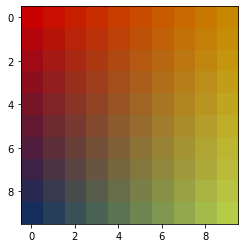

In [3]:
# Create colour-emotion space

dim = 10
color_space = np.zeros((dim, dim, 3))

val_neg = np.array([200, 0, 0])
val_pos = np.array([200, 150, 0])
ars_neg = np.array([0, 50, 100])
ars_pos = np.array([200, 230, 80])

def interpolate_colour(R_neg, R_pos, G_neg, G_pos, B_neg, B_pos, step):
    R = np.floor(R_neg + (R_pos - R_neg) * step)
    G = np.floor(G_neg + (G_pos - G_neg) * step)
    B = np.floor(B_neg + (B_pos - B_neg) * step)
    return R, G, B

for i in range(dim):
    dim1_R, dim1_G, dim1_B = interpolate_colour(val_neg[0], ars_neg[0], val_neg[1], ars_neg[1], val_neg[2], ars_neg[2], i/dim)
    dim2_R, dim2_G, dim2_B = interpolate_colour(val_pos[0], ars_pos[0], val_pos[1], ars_pos[1], val_pos[2], ars_pos[2], i/dim)
    for j in range(dim):
        color_R, color_G, color_B = interpolate_colour(dim1_R, dim2_R, dim1_G, dim2_G, dim1_B, dim2_B, j/dim)
        color_space[i,j,0] = color_R
        color_space[i,j,1] = color_G
        color_space[i,j,2] = color_B
        
color_space = color_space.astype(int)

plt.figure()
plt.imshow(color_space)

In [4]:
idx = 500  # File index

# Load models

class CNN_Fixed(torch.nn.Module):
    
    def __init__(self):
        super(CNN_Fixed, self).__init__()
        
        self.convnet = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), nn.PReLU(),
                                     nn.Dropout(0.1), nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), nn.PReLU(),
                                     nn.Dropout(0.1), nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.PReLU(),
                                     nn.Dropout(0.1), nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.PReLU(),
                                     nn.Dropout(0.1), nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.PReLU(),
                                     nn.Dropout(0.1), nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear((128*3*3), 128),
                                nn.PReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(128, 10)
                                )

    def forward(self, x):
        x = x.unsqueeze(1)
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)
    
model_cnn_arousal = CNN_Fixed()
model_cnn_valence = CNN_Fixed()

model_cnn_arousal.load_state_dict(torch.load('MinValLossModel_Arousal.pth'))
model_cnn_valence.load_state_dict(torch.load('MinValLossModel_Valence.pth'))

# Load spectrograms

path_audio = 'MEMD_audio'

list_wav = []
for path, subdirs, files in os.walk(path_audio):
    for filename in files:
        if filename.endswith('.wav'):
            list_wav.append(os.path.join(path, filename))

list_wav = sorted(list_wav)
list_wav.sort(key = lambda f:int(''.join(filter(str.isdigit,f))))

start_audio = int(44100*15)

frame_size = 4096
hop_size = 2048
num_freq = 96
specs_per_file = 6

audio_matrix_frames = np.zeros((specs_per_file, num_freq, num_freq))

audio, fs = librosa.load(list_wav[idx], sr=44100)
audio = audio[start_audio:]

spec = librosa.feature.melspectrogram(audio, sr=44100, n_fft=frame_size, hop_length=hop_size, n_mels=num_freq)
spec = np.log((abs(spec)*1e-2)+1e-16)
spec = (spec-np.min(spec))/(np.max(spec)-np.min(spec))

for i in range(specs_per_file):
    audio_matrix_frames[i] = spec[:,int(i*num_freq):int((i+1)*num_freq)]

Tensor_Test = torch.from_numpy(audio_matrix_frames).type(torch.FloatTensor)

# Retrieve Arousal

with torch.no_grad():
    
    model_cnn_arousal.eval()

    predictions = model_cnn_arousal(Tensor_Test)

    predictions = predictions.squeeze(-1)
    predictions = predictions.double()

sfmx = torch.nn.LogSoftmax()
Arousal = np.zeros(6)
for idx in range(6):
    Arousal[idx] = sfmx(predictions[idx]).argmax()
     
# Retrieve Valence

with torch.no_grad():

    model_cnn_valence.eval()

    predictions = model_cnn_valence(Tensor_Test)

    predictions = predictions.squeeze(-1)
    predictions = predictions.double()

sfmx = torch.nn.LogSoftmax()
Valence = np.zeros(6)
for idx in range(6):
    Valence[idx] = sfmx(predictions[idx]).argmax()

/home/alejandro/anaconda3/envs/mip/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/alejandro/anaconda3/envs/mip/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [5]:
Arousal

array([5., 6., 6., 4., 4., 4.])

In [6]:
Valence

array([6., 6., 5., 5., 5., 5.])

In [7]:
import IPython.display as ipd
import soundfile as sf
sf.write('audio.wav', audio, 44100)
ipd.Audio('audio.wav')

In [8]:
def substract_rgb(img, colour_diff):
    img = img.astype('float64')
    img[:,:,0] -= colour_diff[0]
    img[:,:,1] -= colour_diff[1]
    img[:,:,2] -= colour_diff[2]
    img = img.clip(min=0)
    img = img.clip(max=255)
    img = img.astype('uint8')
    return img

cam = cv2.VideoCapture(0)
c = 0
colour_diff = np.zeros(3)

start = time.time()
plt.figure()

while True:
    
    ret_val, img = cam.read()
    img = substract_rgb(img, colour_diff)
    cv2.imshow('Camera', img)
    
    if cv2.waitKey(1) == 27: 
        break  # esc to quit
    
    if ((time.time()-start)>=4.5):
        
        mean_r = np.mean(img[:,:,0])
        mean_g = np.mean(img[:,:,1])
        mean_b = np.mean(img[:,:,2])
        
        colour_music = color_space[int(Arousal[c]),int(Valence[c])]
        colour_sight = np.array([mean_r, mean_g, mean_b])
        
        colour_diff = -0.7*(colour_sight-colour_music)
        
        start = time.time()
        c += 1
        
cv2.destroyAllWindows()

<Figure size 432x288 with 0 Axes>

In [9]:
colour_sight

array([ 97.21268555, 131.00867839, 203.85380859])

In [10]:
start = time.time()

a = 1
for a in range(10000000):
    b = 1

print(time.time() - start)

0.3881690502166748
